In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import warnings
warnings.filterwarnings("ignore")

# import matplotlib.pyplot as plt
# %matplotlib inline

import tensorflow as tf

import numpy as np
from npde_master.utils import gen_data, plot_model, eval_model, em_int
from npde_master.npde_helper import build_model, fit_model, save_model, load_model


import os
from os.path import join as oj
import pandas as pd
import numpy as np
from scipy.stats import sem
from collections import defaultdict

from utils.utils import cwd, set_up_plotting

plt = set_up_plotting()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.






In [2]:
def create_and_fit_model(t, Y, de_type):
    sess = tf.InteractiveSession()

    de_type = de_type.lower()
    if de_type == 'ode':

    # for ode
        npde = build_model(sess, t, Y, model='ode', sf0=1.0, ell0=np.ones(2), W=6, ktype="id")

        prior_sn = npde.sn.eval()
        # print(f'Prior noise variances are {prior_sn}.')

        npde = fit_model(sess, npde, t, Y, num_iter=500, print_every=50, eta=0.02, plot_=False)

        posterior_sn = npde.sn.eval()

    elif de_type == 'vdp':
    # for vdp
        npde = build_model(sess, t, Y, model='sde', sf0=1.0, ell0=np.ones(2), W=6, ellg0=[1e5], ktype="id")

        prior_sn = npde.sn.eval()

        npde = fit_model(sess, npde, t, Y, Nw=100, num_iter=1000, print_every=50, eta=0.02, plot_=False)

        posterior_sn = npde.sn.eval()

    elif de_type == 'sde':
    # for sde 
        npde = build_model(sess, t, Y, model='sde', sf0=1.0, ell0=np.ones(2), W=6, ellg0=[1.0], ktype="id", fix_Z=True)

        prior_sn = npde.sn.eval()

        npde = fit_model(sess, npde, t, Y, Nw=50, num_iter=1000, print_every=50, eta=0.01, plot_=False)

        posterior_sn = npde.sn.eval()
    
    else:
        raise NotImplementedError(f"DE type: {de_type} not implemented ")
    
    return npde, prior_sn, posterior_sn

def get_times(overall_t, overall_Y, baseline_obs):
    baseline_obs = np.unique(baseline_obs, axis=0)

    baseline_times = []
    baseline_obs_time_synced = []
    for t_i, y_i in zip(overall_t, overall_Y):
        for ob_i in baseline_obs:
            if (y_i == ob_i).all():
                baseline_times.append(t_i)
                baseline_obs_time_synced.append(list(y_i))
                
    baseline_obs_time_synced = np.asarray(baseline_obs_time_synced)
    baseline_times = np.asarray(baseline_times)
    assert len(baseline_times) == len(baseline_obs_time_synced)
    return baseline_times, baseline_obs_time_synced 


In [8]:
from npde_master.utils import  em_int, vdp
from matplotlib.gridspec import GridSpec


def plot_vector_field(npde, t, Y, Nw=1, de_type='ODE'):
    print(npde)
    Z = npde.Z.eval()
    U = npde.U
    if npde.whiten:
        Lz = tf.cholesky(npde.Kzz())
        U = tf.matmul(Lz,U)
    U = U.eval()
    D = Z.shape[1]
    if D == 2:
        ts = np.linspace(np.min(t[0]),np.max(t[0])*3,len(t[0])*12)
    else:
        ts = np.linspace(np.min(t[0]),np.max(t[0]),len(t[0])*10)

    vdpts = np.linspace(np.min(t[0]),np.max(t[0])*3,len(t[0])*10)
    g = lambda x,t: 0
    true_path = em_int(vdp,g,Y[0][0],vdpts)

    x0 = np.vstack([Y_[0] for Y_ in Y])
    if npde.name is 'npode':
        X = npde.forward(x0,[ts]*len(Y))
        X = X[0].eval()
        plt.figure(1,figsize=(10, 6))
        gs = GridSpec(4, 2)
        ax1 = plt.subplot(gs[0:4,0])
        pathh, = ax1.plot(X[:,0],X[:,1],linestyle='-.',label='estimated path', color='C1',linewidth=1)
        if npde.kern.ktype == "id":
            ilh = ax1.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k',label='inducing locations')
            ivh = ax1.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k',label='inducing vectors')
        if Y is not None:
            dh, = ax1.plot(Y[0][:,0],Y[0][:,1],'ro',markersize=7,label='data points')
        ax1.set_xlabel('$x_1$', fontsize=30)
        ax1.set_ylabel('$x_2$', fontsize=30)
        ax1.legend(handles=[pathh,ilh,ivh,dh],loc=2,fontsize='medium')

        plt.tight_layout()
        plt.savefig(f'vector_field-{de_type}.png', dpi=200, bbox_inches='tight')
        plt.show()

    elif npde.name is 'npsde':
        ts = np.linspace(np.min(t[0]),np.max(t[0])*3,len(t[0])*20)
        X = npde.forward(x0,[ts]*len(Y),Nw=Nw)
        X = [x.eval() for x in X] # list of (Nw,len(ts),d)
        print([x.shape for x in X])
        plt.figure(1,figsize=(10, 6))
        gs = GridSpec(4, 2)
        ax1 = plt.subplot(gs[0:4,0])
        for j in range(len(X)):
            for i in range(X[j].shape[0]):
                pathh, = ax1.plot(X[j][i,:,0],X[j][i,:,1],linestyle='-.', color='C1',linewidth=1,label='sampled trajectories')
        for j in range(len(X)):
            dh, = ax1.plot(Y[j][:,0],Y[j][:,1],'-ro',markersize=7,linewidth=1.5,label='data points')
        if npde.kern.ktype == "id":
            ilh = ax1.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k',label='inducing locations')
            ivh = ax1.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k',label='inducing vectors')
        ax1.set_xlabel('$x_1$', fontsize=30)
        ax1.set_ylabel('$x_2$', fontsize=30)
        ax1.legend(handles=[pathh,ilh,ivh,dh],loc=2,fontsize=20)
        ts2 = np.linspace(np.min(ts),np.max(ts),len(ts)*3)
        true_vdp = em_int(vdp,lambda x,t:0,Y[0][0,:],ts2)

        plt.tight_layout()
        plt.savefig(f'vector_field-{de_type}.png', dpi=200, bbox_inches='tight')
        plt.show()
    return

def plot_paths_over_time(npde, t, Y, Nw=1, de_type='ODE'):    
    print(npde)
    Z = npde.Z.eval()
    U = npde.U
    if npde.whiten:
        Lz = tf.cholesky(npde.Kzz())
        U = tf.matmul(Lz,U)
    U = U.eval()
    D = Z.shape[1]
    if D == 2:
        ts = np.linspace(np.min(t[0]),np.max(t[0])*3,len(t[0])*12)
    else:
        ts = np.linspace(np.min(t[0]),np.max(t[0]),len(t[0])*10)

    vdpts = np.linspace(np.min(t[0]),np.max(t[0])*3,len(t[0])*10)
    g = lambda x,t: 0
    true_path = em_int(vdp,g,Y[0][0],vdpts)

    x0 = np.vstack([Y_[0] for Y_ in Y])
    if npde.name is 'npode':
        X = npde.forward(x0,[ts]*len(Y))
        X = X[0].eval()
        for d in range(D):
            plt.figure(figsize=(9, 6))
    #         ax = plt.subplot(gs[d,1])
            vdph, = plt.plot(vdpts,true_path[:,d],label='true path')
            trajh, = plt.plot(ts,X[:,d],label='estimated path', linestyle='-.', color='C1')
            if Y is not None:
                dh, = plt.plot(t[0],Y[0][:,d],'ro',markersize=7,label='data points')
            plt.xlabel('$t$', fontsize=28)
            plt.ylabel('$x_{:d}$'.format(d+1), fontsize=28)
            plt.xlim(0, 20)

            plt.legend(handles=[trajh,vdph,dh],loc=1)
            
            plt.tight_layout()
            plt.savefig(f'path-{de_type}-x{d+1}.png', dpi=200, bbox_inches='tight')
            plt.show()

    elif npde.name is 'npsde':
        ts = np.linspace(np.min(t[0]),np.max(t[0])*3,len(t[0])*20)
        X = npde.forward(x0,[ts]*len(Y),Nw=Nw)
        X = [x.eval() for x in X] # list of (Nw,len(ts),d)
        print([x.shape for x in X])
        ts2 = np.linspace(np.min(ts),np.max(ts),len(ts)*3)
        true_vdp = em_int(vdp,lambda x,t:0,Y[0][0,:],ts2)
        for d in range(D):
            plt.figure(figsize=(9, 6))

            vdph, = plt.plot(ts2,true_vdp[:,d],'-',linewidth=2,label='true vdp')
            for i in range(X[0].shape[0]):
                pathh, = plt.plot(ts,X[0][i,:,d],linewidth=0.5,label='samples', linestyle='-.', color='C1')
            datah, = plt.plot(t[0],Y[0][:,d],'ro',markersize=7,label='data')
            plt.xlabel('$t$', fontsize=28)
            plt.ylabel('$x_{:d}$'.format(d+1), fontsize=28)
            plt.xlim(0, 20)

            plt.legend(handles=[pathh,vdph,datah],loc=1)

            plt.tight_layout()
            plt.savefig(f'path-{de_type}-x{d+1}.png', dpi=200, bbox_inches='tight')
            plt.show()
    return

## Plotting trajectories

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
Optimization ends.
name:                  npsde
noise variance:        [0.00936034 0.01092708]
signal variance:       2.2171151130042035
lengthscales:          [0.83494048 1.1852775 ]
diff signal variance:  0.05473080499583794
diff lengthscales:     [100000.00587786]
[(50, 600, 2)]


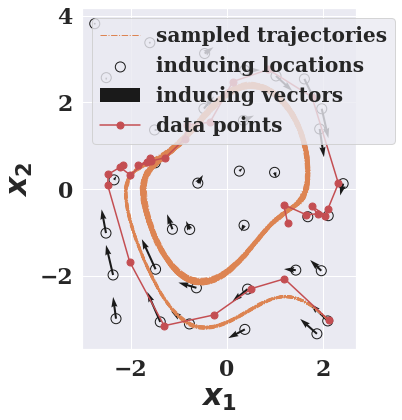

name:                  npsde
noise variance:        [0.00936034 0.01092708]
signal variance:       2.2171151130042035
lengthscales:          [0.83494048 1.1852775 ]
diff signal variance:  0.05473080499583794
diff lengthscales:     [100000.00587786]
[(50, 600, 2)]


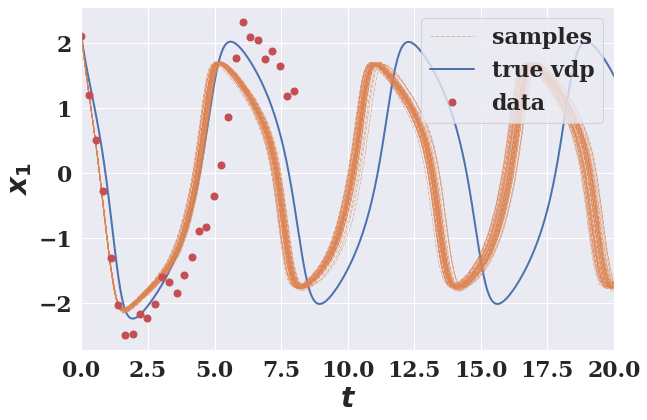

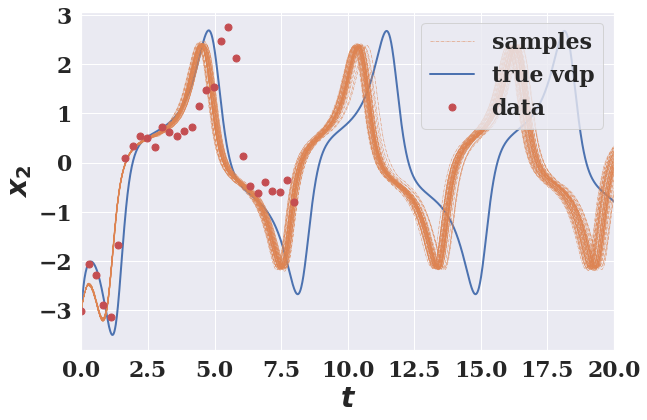

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
Optimization ends.
name:                  npsde
noise variance:        [0.01045011 0.00983076]
signal variance:       2.17610075149055
lengthscales:          [0.83246514 1.21798484]
diff signal variance:  0.07412276895860272
diff lengthscales:     [100000.00643366]
[(50, 600, 2)]


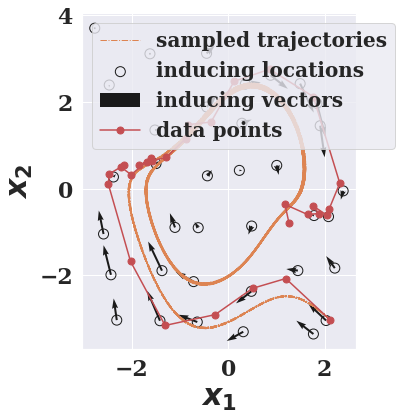

name:                  npsde
noise variance:        [0.01045011 0.00983076]
signal variance:       2.17610075149055
lengthscales:          [0.83246514 1.21798484]
diff signal variance:  0.07412276895860272
diff lengthscales:     [100000.00643366]
[(50, 600, 2)]


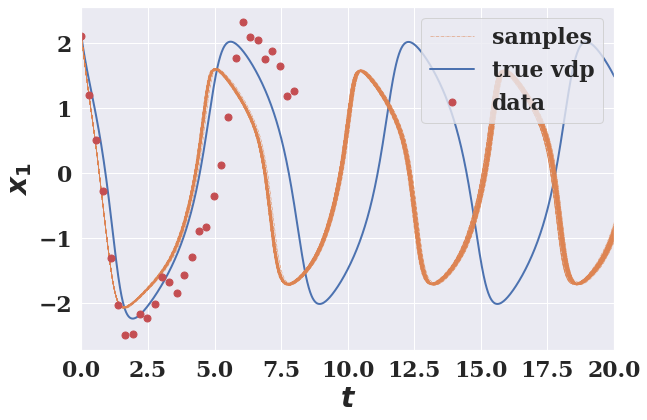

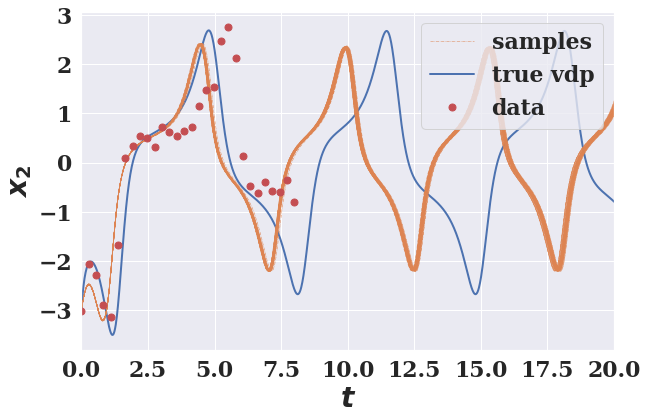

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
Optimization ends.
name:                  npsde
noise variance:        [0.01059858 0.0098267 ]
signal variance:       2.094212932073016
lengthscales:          [0.84681453 1.20949664]
diff signal variance:  0.07865469679320555
diff lengthscales:     [100000.00776847]
[(50, 600, 2)]


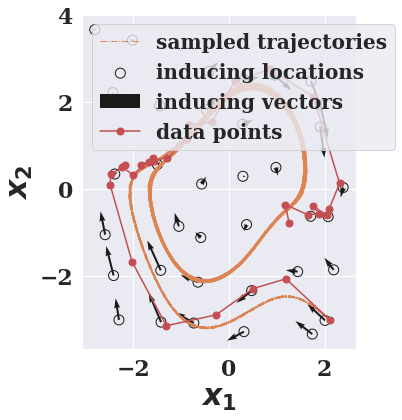

name:                  npsde
noise variance:        [0.01059858 0.0098267 ]
signal variance:       2.094212932073016
lengthscales:          [0.84681453 1.20949664]
diff signal variance:  0.07865469679320555
diff lengthscales:     [100000.00776847]
[(50, 600, 2)]


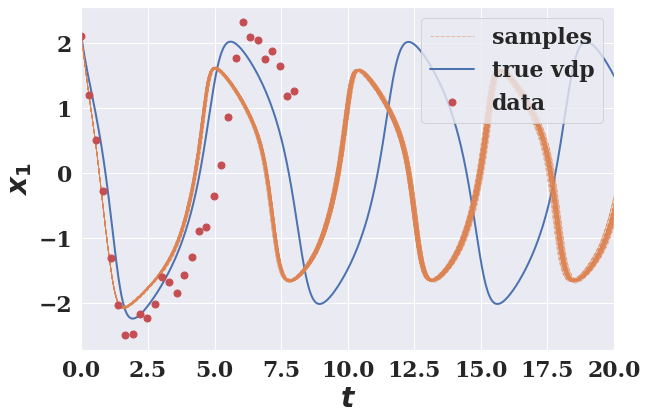

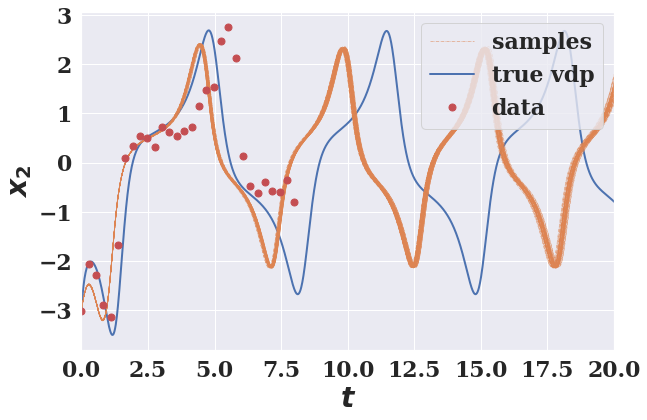

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
Optimization ends.
name:                  npsde
noise variance:        [0.01068149 0.01040068]
signal variance:       2.2310728501248587
lengthscales:          [0.82503415 1.21009332]
diff signal variance:  0.07566868461487551
diff lengthscales:     [100000.00735808]
[(50, 600, 2)]


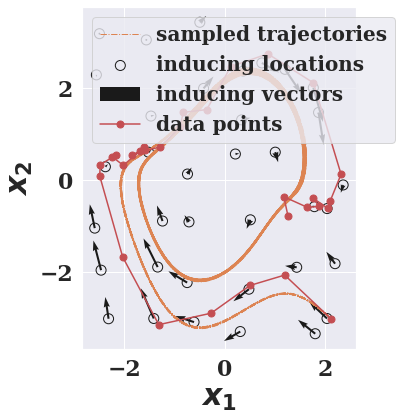

name:                  npsde
noise variance:        [0.01068149 0.01040068]
signal variance:       2.2310728501248587
lengthscales:          [0.82503415 1.21009332]
diff signal variance:  0.07566868461487551
diff lengthscales:     [100000.00735808]
[(50, 600, 2)]


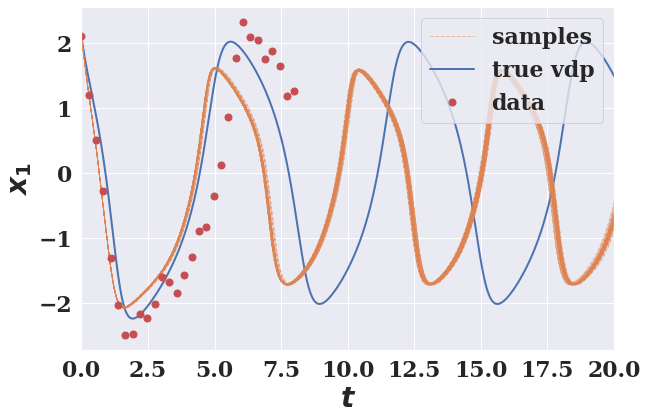

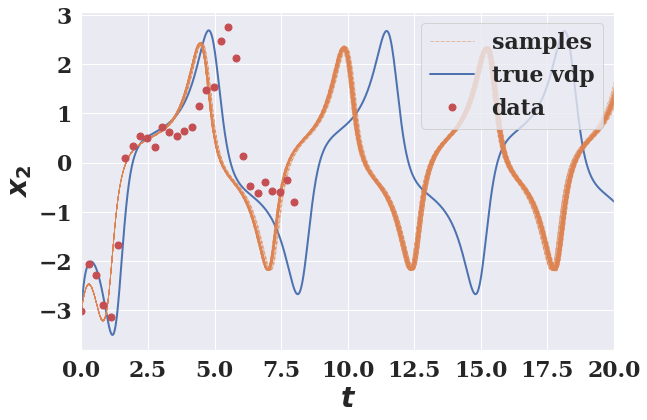

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
Optimization ends.
name:                  npsde
noise variance:        [0.01074814 0.01458033]
signal variance:       2.182566343226157
lengthscales:          [0.8452545  1.19839157]
diff signal variance:  0.08374334719407267
diff lengthscales:     [100000.00721467]
[(50, 600, 2)]


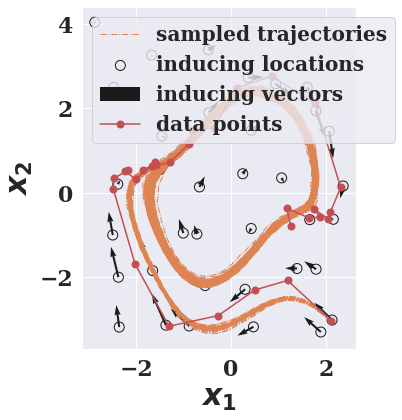

name:                  npsde
noise variance:        [0.01074814 0.01458033]
signal variance:       2.182566343226157
lengthscales:          [0.8452545  1.19839157]
diff signal variance:  0.08374334719407267
diff lengthscales:     [100000.00721467]
[(50, 600, 2)]


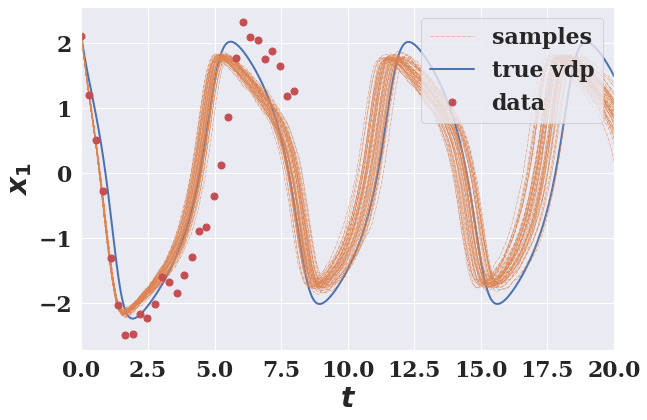

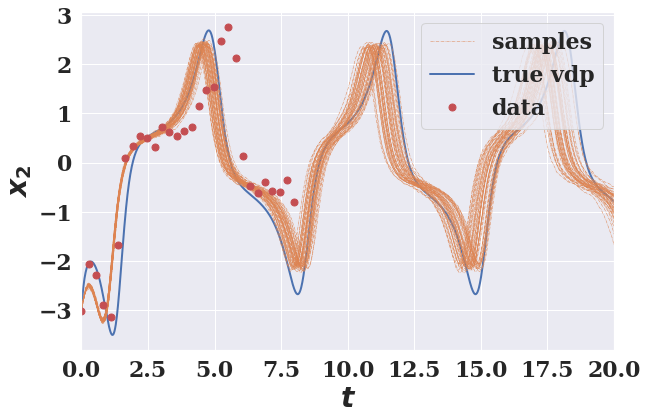

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
Optimization ends.
name:                  npsde
noise variance:        [0.00962161 0.0096646 ]
signal variance:       2.0709501651919804
lengthscales:          [0.83523653 1.18214466]
diff signal variance:  0.0690608037693379
diff lengthscales:     [100000.01273669]
[(50, 600, 2)]


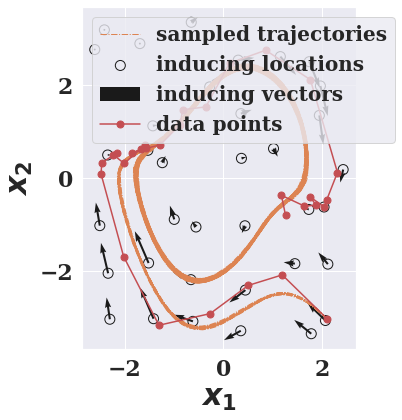

name:                  npsde
noise variance:        [0.00962161 0.0096646 ]
signal variance:       2.0709501651919804
lengthscales:          [0.83523653 1.18214466]
diff signal variance:  0.0690608037693379
diff lengthscales:     [100000.01273669]
[(50, 600, 2)]


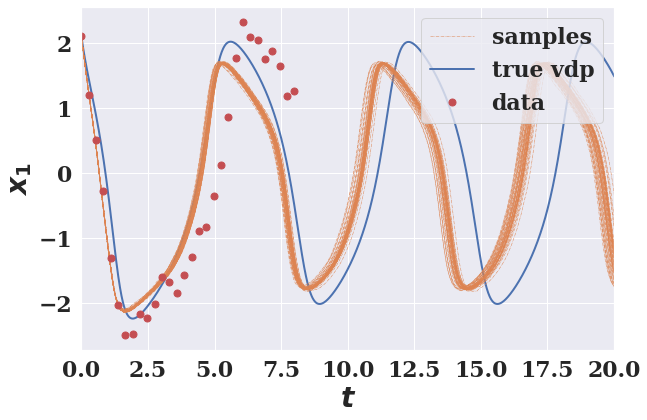

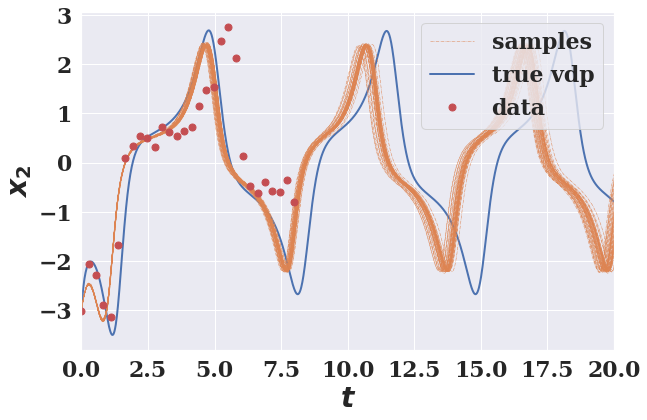

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
Optimization ends.
name:                  npsde
noise variance:        [0.01039093 0.01001903]
signal variance:       2.3065640687748563
lengthscales:          [0.80181373 1.17416687]
diff signal variance:  0.17688877439722545
diff lengthscales:     [99999.99998834]
[(50, 600, 2)]


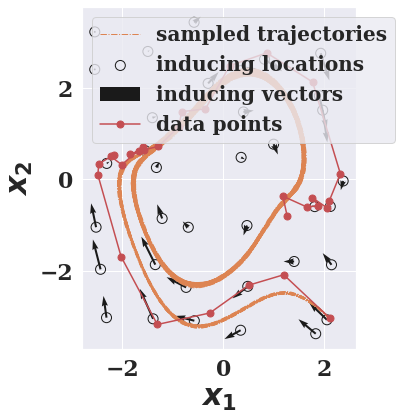

name:                  npsde
noise variance:        [0.01039093 0.01001903]
signal variance:       2.3065640687748563
lengthscales:          [0.80181373 1.17416687]
diff signal variance:  0.17688877439722545
diff lengthscales:     [99999.99998834]
[(50, 600, 2)]


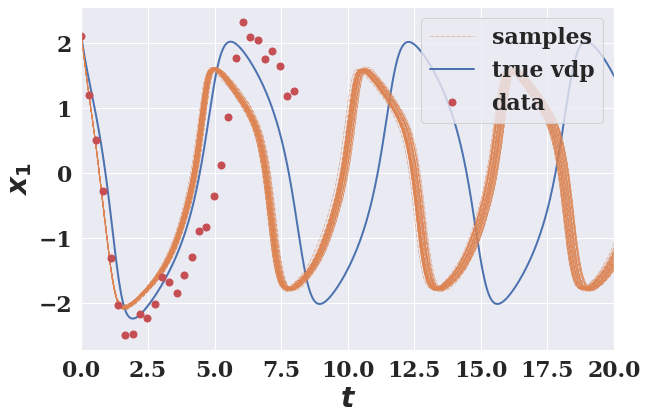

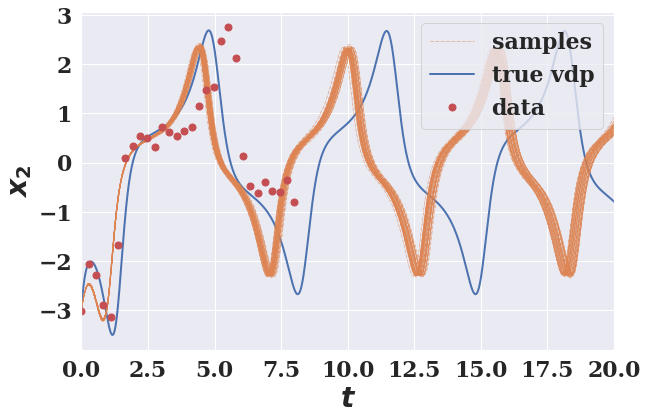

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
Optimization ends.
name:                  npsde
noise variance:        [0.010176   0.01265228]
signal variance:       2.1676297457048572
lengthscales:          [0.84724443 1.18176183]
diff signal variance:  0.05995856187058407
diff lengthscales:     [100000.00108661]
[(50, 600, 2)]


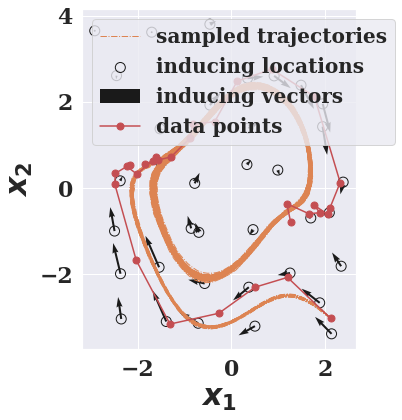

name:                  npsde
noise variance:        [0.010176   0.01265228]
signal variance:       2.1676297457048572
lengthscales:          [0.84724443 1.18176183]
diff signal variance:  0.05995856187058407
diff lengthscales:     [100000.00108661]
[(50, 600, 2)]


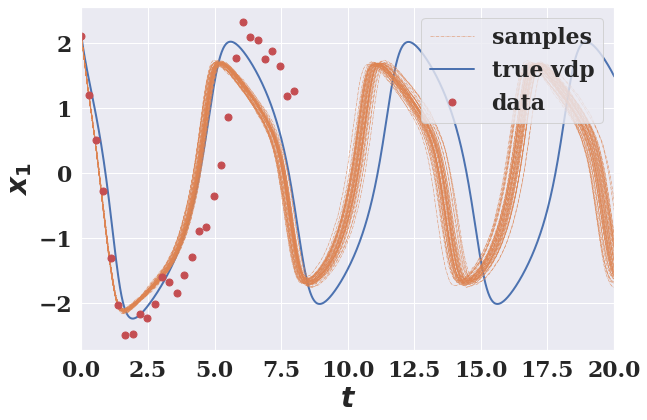

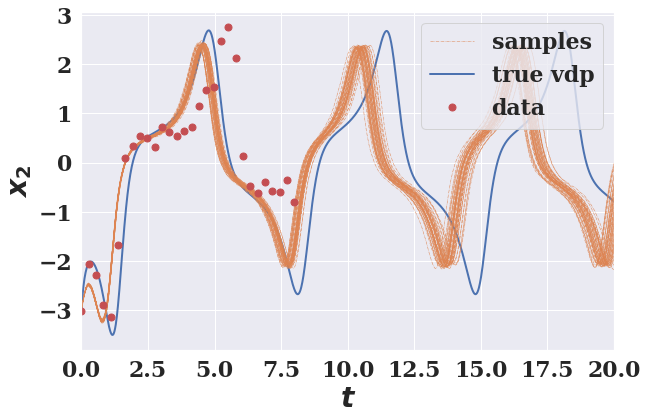

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
Optimization ends.
name:                  npsde
noise variance:        [0.01217631 0.01561717]
signal variance:       2.2965114991525257
lengthscales:          [0.82226267 1.13771007]
diff signal variance:  0.12414325631562485
diff lengthscales:     [100000.00981917]
[(50, 600, 2)]


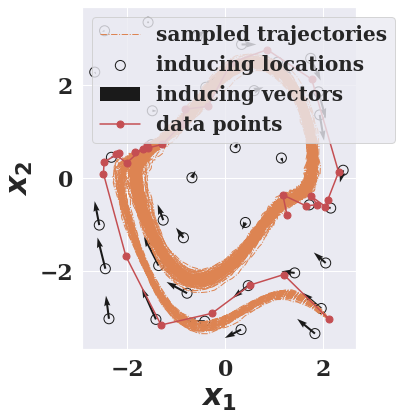

name:                  npsde
noise variance:        [0.01217631 0.01561717]
signal variance:       2.2965114991525257
lengthscales:          [0.82226267 1.13771007]
diff signal variance:  0.12414325631562485
diff lengthscales:     [100000.00981917]
[(50, 600, 2)]


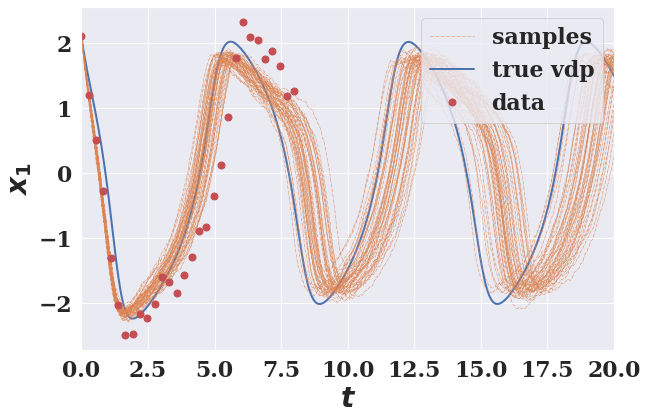

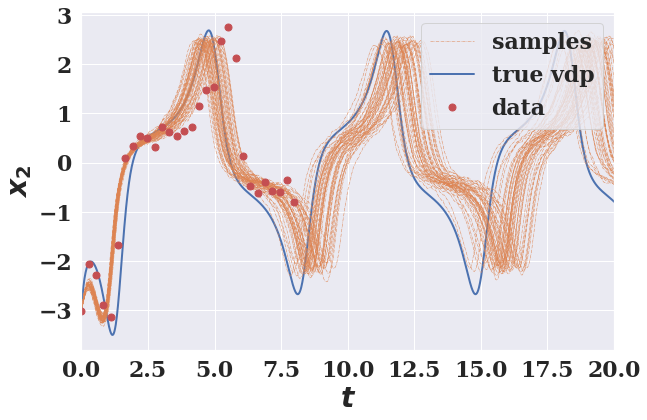

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
Optimization ends.
**** plots for agent:1 ****
name:                  npsde
noise variance:        [0.00088903 0.00231191]
signal variance:       2.6983677248048274
lengthscales:          [0.32628105 0.4126444 ]
diff signal variance:  0.3199273215322805
diff lengthscales:     [99999.99996358]
[(50, 100, 2)]


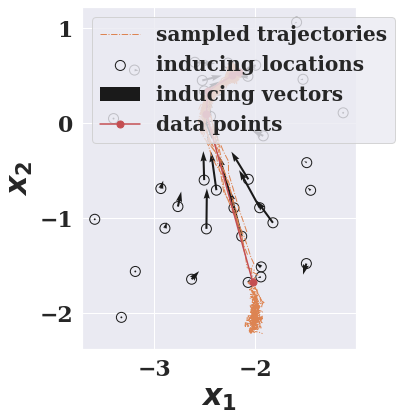

name:                  npsde
noise variance:        [0.00088903 0.00231191]
signal variance:       2.6983677248048274
lengthscales:          [0.32628105 0.4126444 ]
diff signal variance:  0.3199273215322805
diff lengthscales:     [99999.99996358]
[(50, 100, 2)]


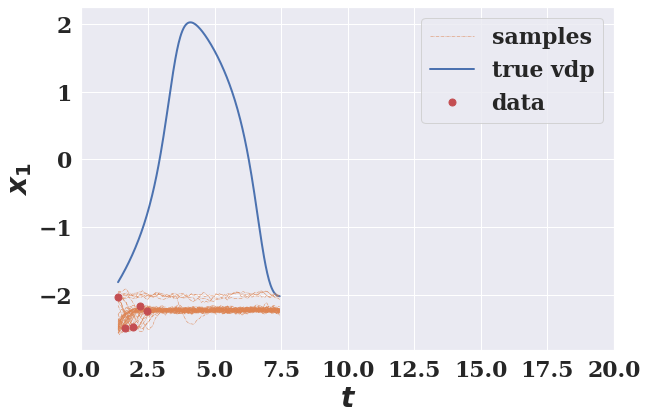

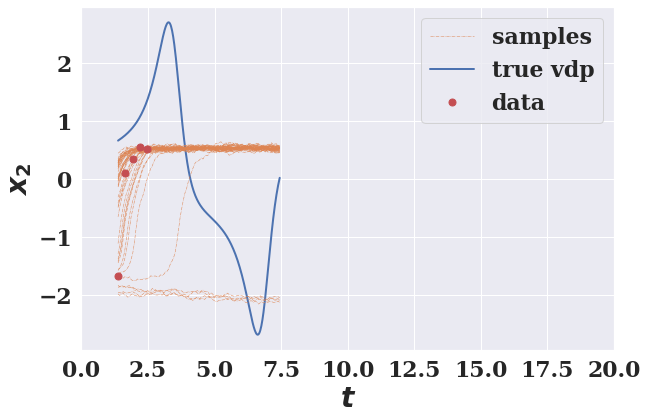

**** end plots for agent:1  end ****
Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
Optimization ends.
**** plots for agent:2 ****
name:                  npsde
noise variance:        [0.01868681 0.01020944]
signal variance:       1.053416082944659
lengthscales:          [0.51814152 1.06297001]
diff signal variance:  0.06673842964650657
diff lengthscales:     [100000.00126754]
[(50, 160, 2)]


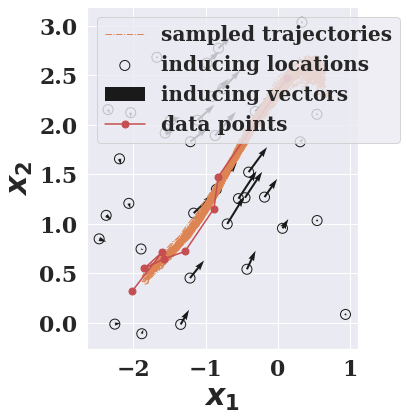

name:                  npsde
noise variance:        [0.01868681 0.01020944]
signal variance:       1.053416082944659
lengthscales:          [0.51814152 1.06297001]
diff signal variance:  0.06673842964650657
diff lengthscales:     [100000.00126754]
[(50, 160, 2)]


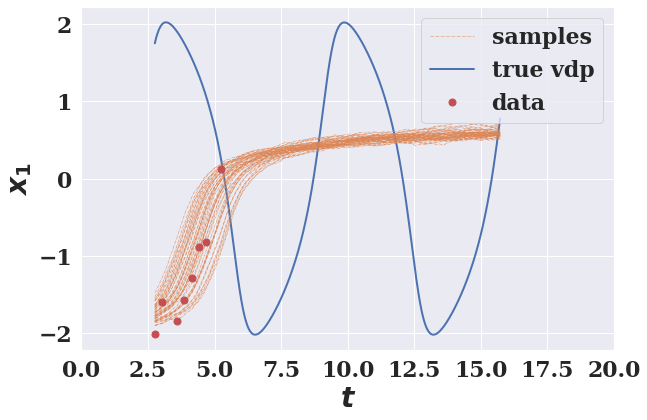

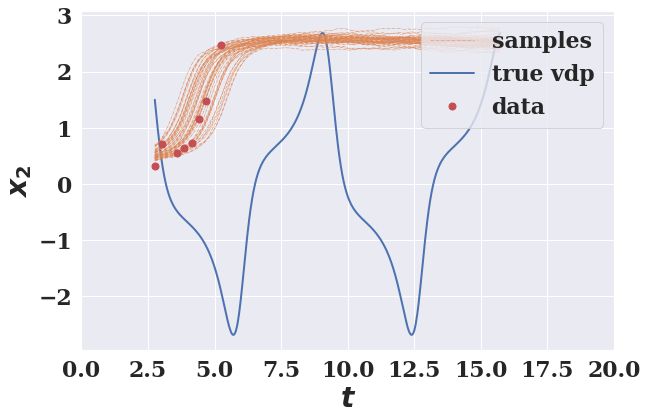

**** end plots for agent:2  end ****
Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
Optimization ends.
**** plots for agent:3 ****
name:                  npsde
noise variance:        [0.02324246 0.01955325]
signal variance:       1.3315346792356617
lengthscales:          [1.0376296  0.58911416]
diff signal variance:  0.3077455413300254
diff lengthscales:     [99999.99936614]
[(50, 140, 2)]


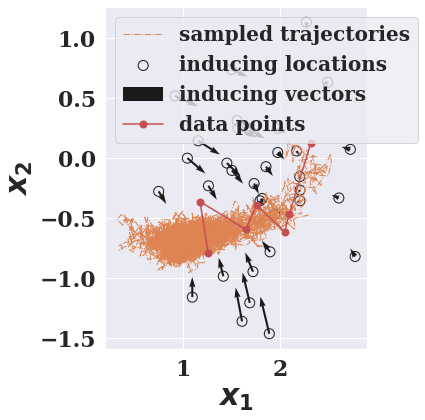

name:                  npsde
noise variance:        [0.02324246 0.01955325]
signal variance:       1.3315346792356617
lengthscales:          [1.0376296  0.58911416]
diff signal variance:  0.3077455413300254
diff lengthscales:     [99999.99936614]
[(50, 140, 2)]


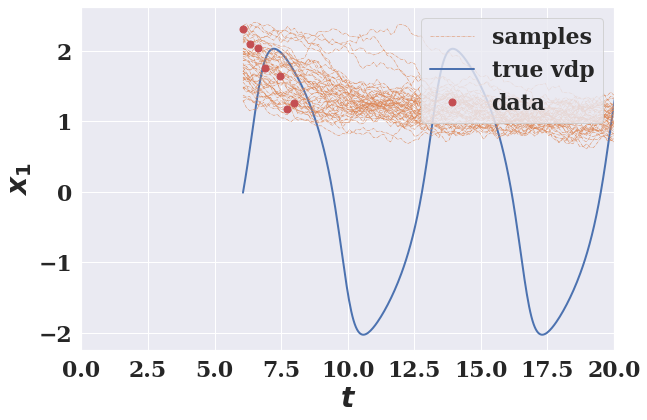

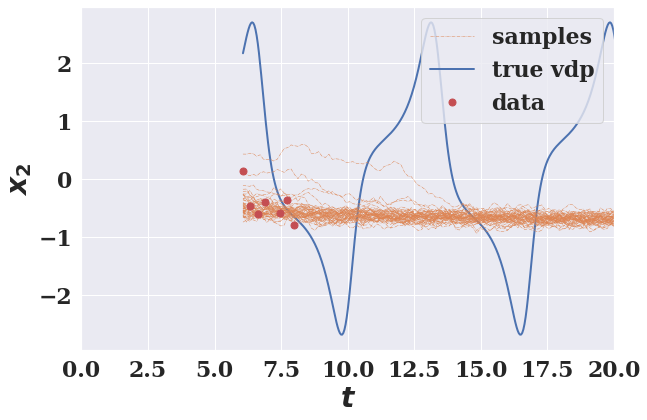

**** end plots for agent:3  end ****


In [9]:
local_dir = oj('results')

setting = 'DE'
trajectory_index = 2
trial_index = 0

for de_type in ['VDP', 'SDE'][:1]:
    with cwd(oj(local_dir, setting)):
        result_datas = []
        for file in os.listdir():
            if file.endswith('.npz') and de_type.upper() in file:
                result_datas.append(np.load(file, allow_pickle=True))
        
        obs = result_datas[trial_index]['obs'].item()
        times = result_datas[trial_index]['times']

        overall_t = result_datas[trial_index]['t'][trajectory_index]
        overall_Y = result_datas[trial_index]['Y'][trajectory_index]

        os.makedirs(de_type+'-trajectories', exist_ok=True)
        with cwd(de_type+'-trajectories'):
            # for CAL methods
            de_models = []
            for collab_type, baseline_obs in obs.items():

                if 'indiv' in collab_type: continue # not plotting indiv here

                collab_type = collab_type.replace('-avg-mses', '').replace('-mses', '').replace('_obs','')

                ob_times, obs_synced = get_times(overall_t, overall_Y, baseline_obs)
                de_model, prior_sn, posterior_sn = create_and_fit_model([ob_times], [obs_synced], de_type=de_type.lower())
                de_models.append(de_model)

                plot_vector_field(de_model, [ob_times], [obs_synced], Nw=50, de_type=f"{de_type}-{collab_type}")
                plot_paths_over_time(de_model, [ob_times], [obs_synced], Nw=50, de_type=f"{de_type}-{collab_type}")

            # for individual AL
            n_agents = 3
            de_models_indiv = []
            indiv_times, indiv_obs_synced = [], []
            for i in range(n_agents):
                indiv_obs_i = obs['indiv_greedy_obs'][i]
                indiv_times_i, indiv_obs_i_synced =  get_times(overall_t, overall_Y, indiv_obs_i)
                de_model_i, prior_sn_i, posterior_sn_i = create_and_fit_model([indiv_times_i], [indiv_obs_i_synced], de_type=de_type.lower())

                de_models_indiv.append(de_model_i)
                indiv_times.append(indiv_times_i)
                indiv_obs_synced.append(indiv_obs_synced)

                print(f"**** plots for agent:{i+1} ****")
                plot_vector_field(de_model_i, [indiv_times_i], [indiv_obs_i_synced], Nw=50, de_type=f'{de_type}-{i+1}')
                plot_paths_over_time(de_model_i, [indiv_times_i], [indiv_obs_i_synced], Nw=50, de_type=f'{de_type}-{i+1}')
                print(f"**** end plots for agent:{i+1}  end ****")


## Individual greedy models

Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
Optimization ends.
**** plots for agent:1 ****
name:                  npsde
noise variance:        [0.00119537 0.00594944]
signal variance:       2.3281180037695695
lengthscales:          [0.31431632 0.55176934]
diff signal variance:  0.3944515162662775
diff lengthscales:     [100000.00005328]
[(50, 100, 2)]


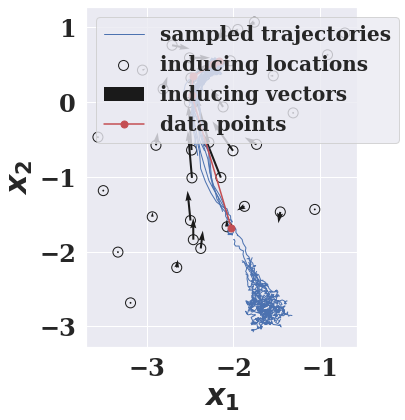

name:                  npsde
noise variance:        [0.00119537 0.00594944]
signal variance:       2.3281180037695695
lengthscales:          [0.31431632 0.55176934]
diff signal variance:  0.3944515162662775
diff lengthscales:     [100000.00005328]
[(50, 100, 2)]


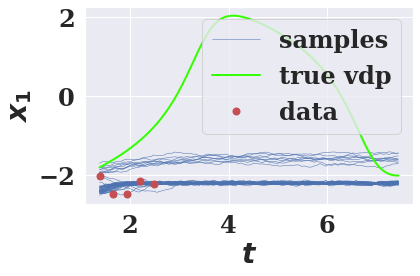

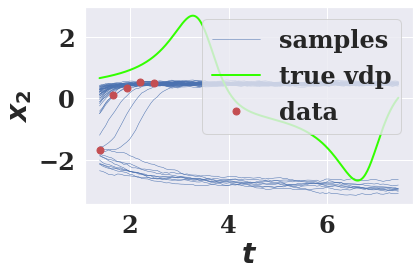

**** end plots for agent:1  end ****
Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
Optimization ends.
**** plots for agent:2 ****
name:                  npsde
noise variance:        [0.02195542 0.01402368]
signal variance:       1.1155511876291817
lengthscales:          [0.52014217 1.00593317]
diff signal variance:  0.037748332557751264
diff lengthscales:     [100000.00069674]
[(50, 160, 2)]


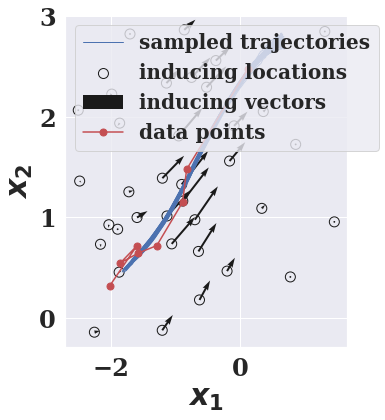

name:                  npsde
noise variance:        [0.02195542 0.01402368]
signal variance:       1.1155511876291817
lengthscales:          [0.52014217 1.00593317]
diff signal variance:  0.037748332557751264
diff lengthscales:     [100000.00069674]
[(50, 160, 2)]


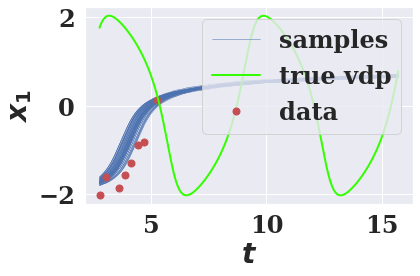

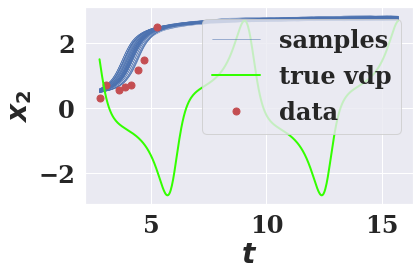

**** end plots for agent:2  end ****
Model being initialized...
Building loss function...
Adam optimizer being initialized...
Optimization starts.
Optimization ends.
**** plots for agent:3 ****
name:                  npsde
noise variance:        [0.00770695 0.0244549 ]
signal variance:       1.535177276628292
lengthscales:          [1.0714815  0.69312595]
diff signal variance:  0.1743475841427852
diff lengthscales:     [99999.99938583]
[(50, 140, 2)]


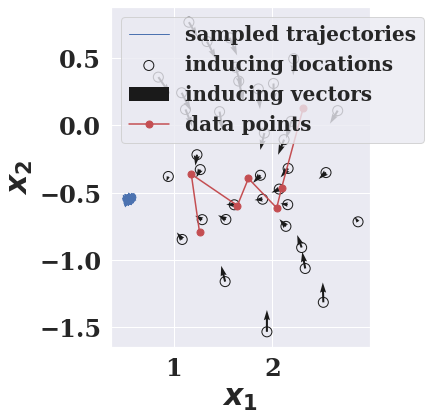

name:                  npsde
noise variance:        [0.00770695 0.0244549 ]
signal variance:       1.535177276628292
lengthscales:          [1.0714815  0.69312595]
diff signal variance:  0.1743475841427852
diff lengthscales:     [99999.99938583]
[(50, 140, 2)]


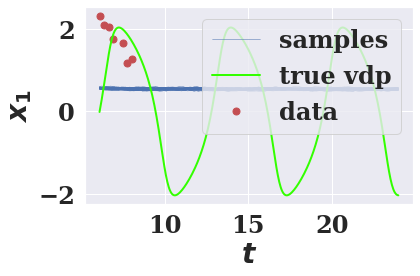

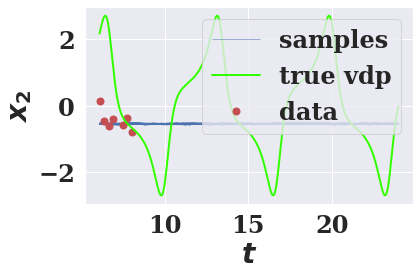

**** end plots for agent:3  end ****


In [48]:
# Individual models
n_agents = 3
de_models = []
prior_sns = []
posterior_sns = []
indiv_times, indiv_obs_synced = [], []
for i in range(n_agents):
    indiv_obs_i = obs['indiv_greedy_obs'][i]
    
    indiv_times_i, indiv_obs_i_synced =  get_times(overall_t, overall_Y, indiv_obs_i)
    
    de_model_i, prior_sn_i, posterior_sn_i = create_and_fit_model([indiv_times_i], [indiv_obs_i_synced], de_type='vdp')

    de_models.append(de_model_i)
    prior_sns.append(prior_sn_i)
    posterior_sns.append(posterior_sn_i)
    indiv_times.append(indiv_times_i)
    indiv_obs_synced.append(indiv_obs_synced)
    
    with cwd(oj('results', 'DE')):
        print(f"**** plots for agent:{i+1} ****")
        plot_vector_field(de_model_i, [indiv_times_i], [indiv_obs_i_synced], Nw=50, de_type=f'VDP-{i+1}')
        plot_paths_over_time(de_model_i, [indiv_times_i], [indiv_obs_i_synced], Nw=50, de_type=f'VDP-{i+1}')
        print(f"**** end plots for agent:{i+1}  end ****")

In [ ]:

with cwd(oj('results', 'DE')):
    for i in range(n_agents):
        de_model_i = de_models[i]
        indiv_times_i = indiv_times[i]
        indiv_obs_i_synced = indiv_obs_synced[i]
        
        print(f"**** plots for agent:{i+1} ****")
        plot_vector_field(de_model_i, [indiv_times_i], [indiv_obs_i_synced], Nw=50, de_type=f'VDP-{i+1}')
        plot_paths_over_time(de_model_i, [indiv_times_i], [indiv_obs_i_synced], Nw=50, de_type=f'VDP-{i+1}')
        print(f"**** end plots for agent:{i+1}  end ****")

**** plots for agent:1 ****
name:                  npsde
noise variance:        [0.5 0.5]
signal variance:       1.0
lengthscales:          [1. 1.]
diff signal variance:  1.0
diff lengthscales:     [100000.]


### Individual model

#### Individual models evaluated on whole support

In [ ]:
t, Y = result_datas[0]['t'][trajectory_index], result_datas[0]['Y'][trajectory_index], 

for i, de_model_i in enumerate(de_models):
    print(f'---- Plotting and evaluating the {i+1} agent on whole support.  ----')
    plot_model(de_model_i, [t], [Y], Nw=50)
    eval_model(de_model_i, [t], [Y], Nw=50)
    print()

#### Individual models evaluated on respective support

---- Plotting and evaluating the 1 agent on respective supports. ----
name:                  npsde
noise variance:        [0.5 0.5]
signal variance:       1.0
lengthscales:          [1. 1.]
diff signal variance:  1.0
diff lengthscales:     [100000.]
[(50, 200, 2)]


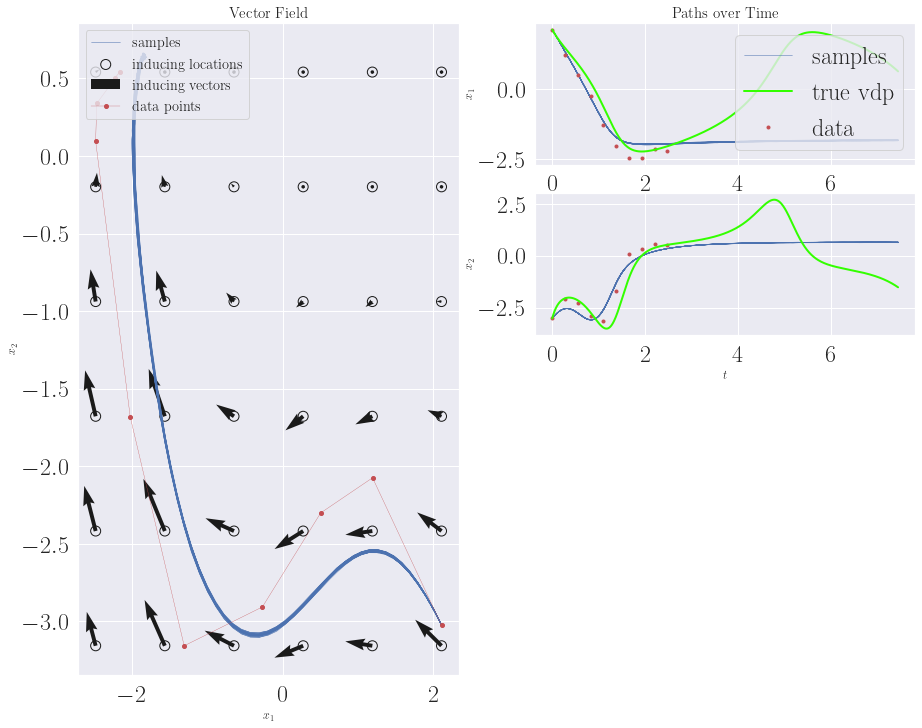

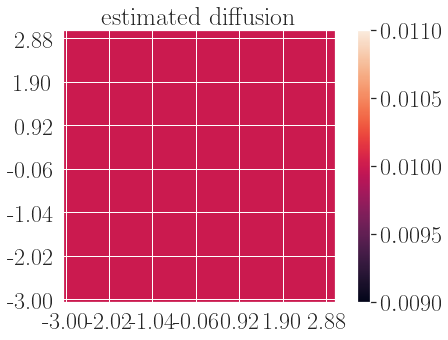

name:                  npsde
noise variance:        [0.5 0.5]
signal variance:       1.0
lengthscales:          [1. 1.]
diff signal variance:  1.0
diff lengthscales:     [100000.]
[(50, 200, 2)]
RMSE over the dimensions is: 3.4665857551653994

---- Plotting and evaluating the 2 agent on respective supports. ----
name:                  npsde
noise variance:        [0.5 0.5]
signal variance:       1.0
lengthscales:          [1. 1.]
diff signal variance:  1.0
diff lengthscales:     [100000.]
[(50, 200, 2)]


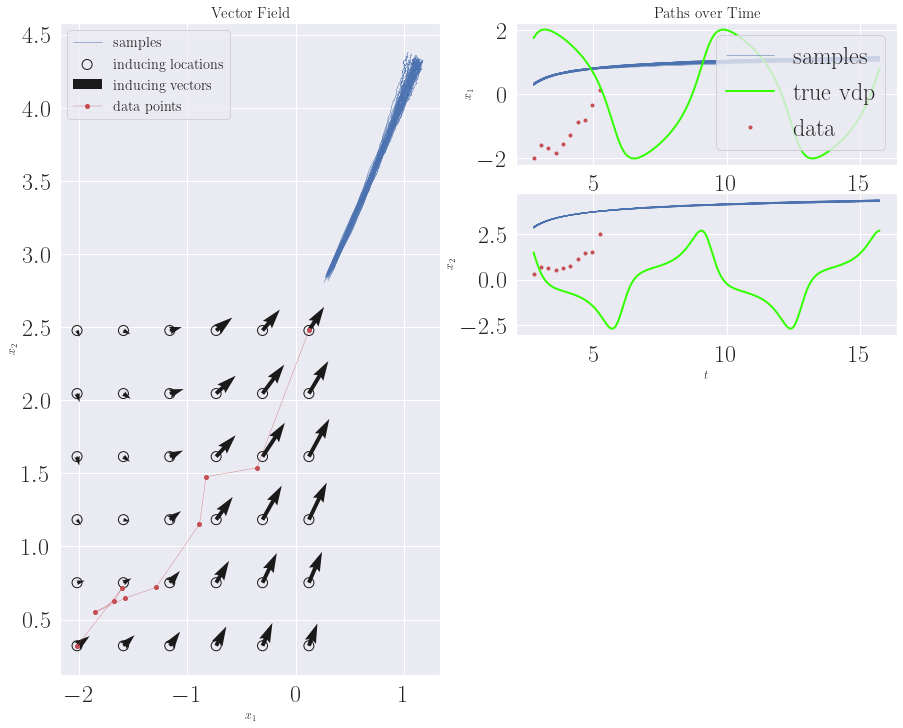

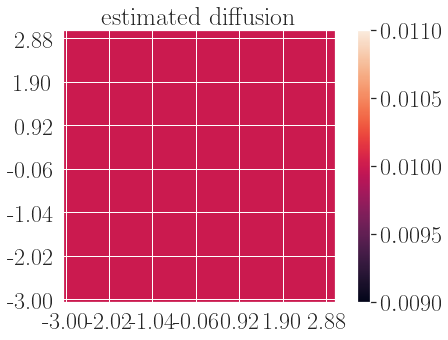

name:                  npsde
noise variance:        [0.5 0.5]
signal variance:       1.0
lengthscales:          [1. 1.]
diff signal variance:  1.0
diff lengthscales:     [100000.]
[(50, 200, 2)]
RMSE over the dimensions is: 13.923777233462854

---- Plotting and evaluating the 3 agent on respective supports. ----
name:                  npsde
noise variance:        [0.5 0.5]
signal variance:       1.0
lengthscales:          [1. 1.]
diff signal variance:  1.0
diff lengthscales:     [100000.]
[(50, 200, 2)]


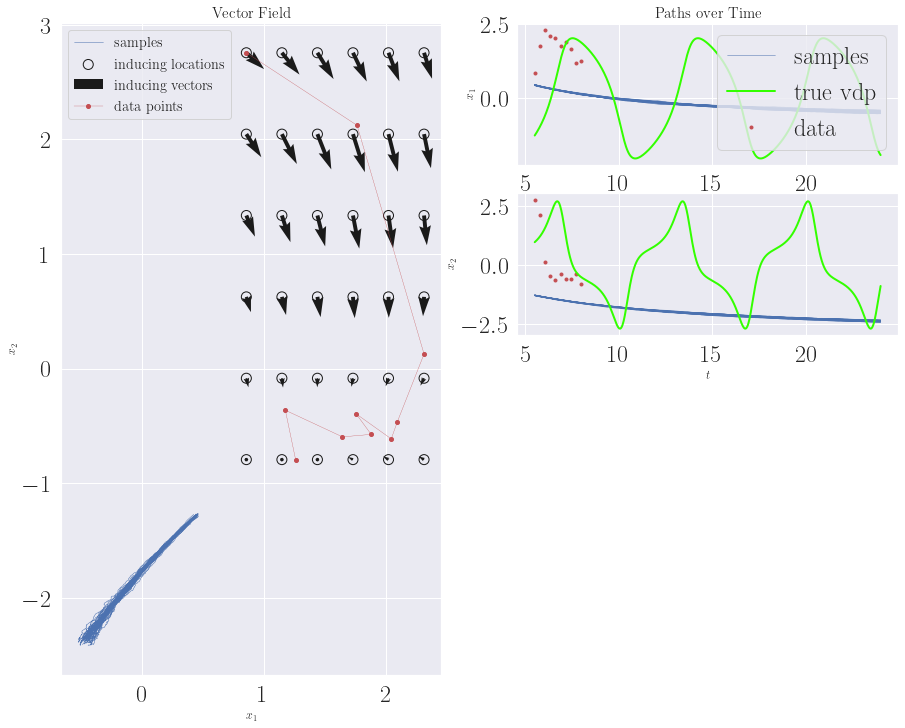

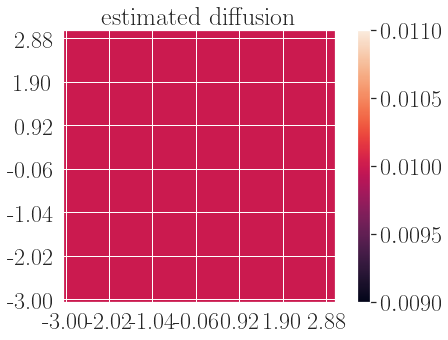

name:                  npsde
noise variance:        [0.5 0.5]
signal variance:       1.0
lengthscales:          [1. 1.]
diff signal variance:  1.0
diff lengthscales:     [100000.]
[(50, 200, 2)]
RMSE over the dimensions is: 3.721483866677187



In [29]:
for i, de_model_i in enumerate(de_models):
    print(f'---- Plotting and evaluating the {i+1} agent on respective supports. ----')
    indi_t, indi_Y = result_datas[0]['times'][i], result_datas[0]['Ss'][i]
    
    plot_model(de_model_i, [indi_t], [indi_Y], Nw=50)
    eval_model(de_model_i, [indi_t], [indi_Y], Nw=50)
    print()